In [1]:
import pandas as pd
# - Cargar el dataset y inspeccionar la estructura
df = pd.read_csv("medium_data-science.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37317 entries, 0 to 37316
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   URL       37317 non-null  object 
 1   Title     37317 non-null  object 
 2   Author    37317 non-null  object 
 3   Taglist   37317 non-null  object 
 4   Stats     37317 non-null  float64
 5   Business  37317 non-null  float64
 6   Coding    37317 non-null  float64
 7   DL        37317 non-null  float64
 8   NLP       37317 non-null  float64
 9   Career    37317 non-null  float64
 10  Algo      37317 non-null  float64
 11  Dataproc  37317 non-null  float64
 12  CV        37317 non-null  float64
 13  Visu      37317 non-null  float64
dtypes: float64(10), object(4)
memory usage: 4.0+ MB


In [2]:
# - Seleccionar columnas numéricas (tipo float64) y eliminar esas columnas del DataFrame
data = df.select_dtypes(include="float64").columns
new_df = df.drop(data, axis=1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37317 entries, 0 to 37316
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   URL      37317 non-null  object
 1   Title    37317 non-null  object
 2   Author   37317 non-null  object
 3   Taglist  37317 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# - Limpieza de la columna Taglist
new_df["Taglist"] = new_df["Taglist"].fillna("").astype(str)
# - Construcción de documentos (corpus)
docs = new_df["Title"] + " " + new_df["Taglist"]

# Crear un vectorizador TF-IDF:
# - max_df=0.9: ignora términos demasiado frecuentes
# - min_df=2: ignora términos muy poco frecuentes
# - stop_words='english': elimina palabras vacías en inglés
vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words="english")
# Generar la matriz TF-IDF a partir del corpus de títulos y etiquetas
X_tfidf = vectorizer.fit_transform(docs)

# - NMF → Non-negative Matrix Factorization, una técnica de reducción de dimensionalidad.
# - n_components=10 → número de tópicos/temas que quieres extraer del corpus.
# - random_state=42 → fija la semilla para que los resultados sean reproducibles.
# - init="nndsvda" → método de inicialización (Nonnegative Double Singular Value Decomposition), que suele dar mejores resultados que el aleatorio.
# - max_iter=500 → máximo de iteraciones para que el algoritmo converja.
nmf = NMF(n_components=10, random_state=42, init="nndsvda", max_iter=500)

# - W = qué temas describen cada documento.
W = nmf.fit_transform(X_tfidf)
# - H = qué palabras describen cada tema.
H = nmf.components_

# - Los nombres (Business, Coding, DL = Deep Learning, etc.) son interpretaciones basadas en las palabras más importantes de cada tema.
topic_names = ["Business","Coding","DL","NLP","Career","Algo","Dataproc","CV","Visu","Stats"]
# - Crear un DataFrame con los temas asignados a documentos
df_topics = pd.DataFrame(W, columns=topic_names)

df_topics.head(10)

,Business,Coding,DL,NLP,Career,Algo,Dataproc,CV,Visu,Stats
0,0.026745,0.000000,0.000000,0.014704,0.000055,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.017402,0.000000,0.000208,0.000551,0.000481,0.004415,0.000000,0.001093,0.040869,0.001084
2,0.000081,0.000000,0.066751,0.000000,0.000000,0.000000,0.000087,0.000000,0.000000,0.000393
3,0.016592,0.000000,0.000005,0.008983,0.000259,0.007928,0.000000,0.003375,0.002164,0.002907
4,0.000620,0.000000,0.000000,0.002037,0.000000,0.001157,0.000000,0.020295,0.001245,0.000000
5,0.017708,0.000595,0.000183,0.005177,0.001080,0.027150,0.000000,0.000889,0.003789,0.000637
6,0.002278,0.000515,0.006165,0.000441,0.000312,0.015314,0.000000,0.002363,0.005266,0.002469
7,0.035359,0.000000,0.035454,0.000000,0.043859,0.003535,0.007850,0.000000,0.000000,0.057002
8,0.008422,0.020919,0.000000,0.000000,0.000589,0.000000,0.056919,0.000000,0.000000,0.000000
9,0.020444,0.000000,0.000000,0.058772,0.001569,0.004958,0.000000,0.063787,0.002995,0.000789


In [4]:
# - Concatenar DataFrames
#    - new_df → contiene los datos originales (sin las columnas float64 que eliminaste). Ej: Title, Taglist, etc.
#    - df_topics → contiene la matriz documento–tema, ya con nombres de tópicos (Business, Coding, DL, etc).
#    - pd.concat([...], axis=1) → concatena por columnas (porque axis=1), uniendo ambos DataFrames fila por fila.

data_df = pd.concat([new_df, df_topics], axis=1)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37317 entries, 0 to 37316
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   URL       37317 non-null  object 
 1   Title     37317 non-null  object 
 2   Author    37317 non-null  object 
 3   Taglist   37317 non-null  object 
 4   Business  37317 non-null  float64
 5   Coding    37317 non-null  float64
 6   DL        37317 non-null  float64
 7   NLP       37317 non-null  float64
 8   Career    37317 non-null  float64
 9   Algo      37317 non-null  float64
 10  Dataproc  37317 non-null  float64
 11  CV        37317 non-null  float64
 12  Visu      37317 non-null  float64
 13  Stats     37317 non-null  float64
dtypes: float64(10), object(4)
memory usage: 4.0+ MB


In [5]:
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

# 📌 Seleccionar las columnas numéricas que corresponden a los tópicos (float64)
topic_cols = data_df.select_dtypes(include="float64").columns

# 📌 Crear una matriz X solo con los valores de los temas por documento
# - fillna(0): rellena valores faltantes con 0
# - .values: convierte el DataFrame en un array de NumPy
X = data_df[topic_cols].fillna(0).values

# 📌 Normalizar la matriz de documentos para evitar que las magnitudes dominen la similitud
X_norm = normalize(X)

# 📌 Calcular la matriz de similitud coseno entre todos los documentos
# - Cada celda (i, j) indica qué tan similares son los documentos i y j
sim_matrix = cosine_similarity(X_norm)

# 📌 Definir función de recomendación
def recommend(idx, top_n=5):
    # Similaridades del documento base con todos los demás
    sim_scores = sim_matrix[idx]
    
    # Ordenar índices por mayor similitud (de mayor a menor)
    # [::-1] → invierte el orden para que queden descendente
    # [1:top_n+1] → omite el propio documento (posición 0) y toma los top N
    similar_idx = sim_scores.argsort()[::-1][1:top_n+1]
    
    # Devolver los títulos y URLs de los documentos más similares
    return data_df.loc[similar_idx, ["Title","URL"]]

# 📌 Ejemplo de uso:
# - Imprime un artículo base y sus 5 artículos más similares
print("Artículo base:", df.loc[10,"Title"])
print(recommend(10, top_n=5))

Artículo base: Data Exploration with Python, Part 1 - District Data Labs - Medium
                                                   Title                                                URL
35     Data Exploration with Python, Part 2 - Distric...  https://medium.com/district-data-labs/data-exp...
34892  5 Pandas Fundamentals | Python - Analytics Vid...  https://medium.com/analytics-vidhya/5-pandas-f...
2781   In 2 mins : Stock Analysis in Python - Rohan J...  https://medium.com/@rohanjoseph_91119/stock-an...
23640  How to make GUI in python for data analysis - ...  https://medium.com/analytics-vidhya/how-to-mak...
29175  Empowered EDA in one line of code with Pandas ...  https://medium.com/@boumlikoumaima/empowered-e...


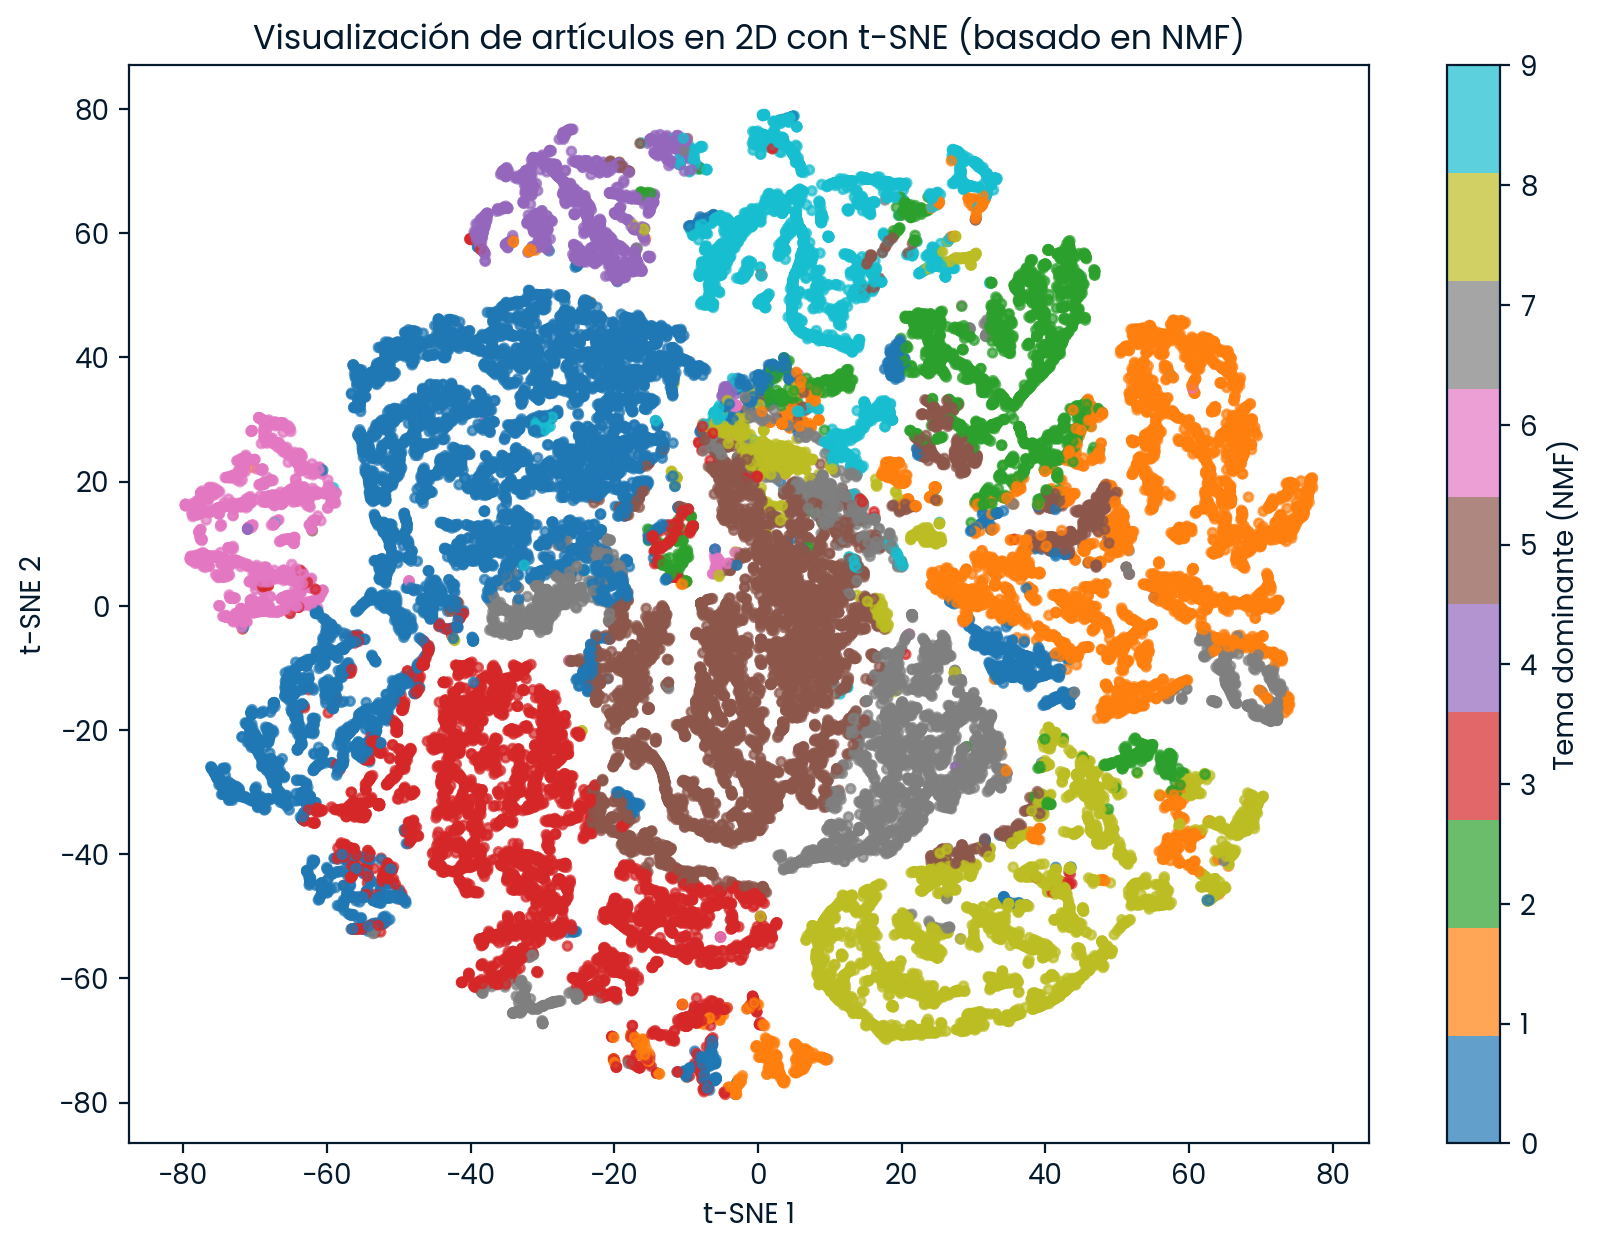

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 📌 Convertir DataFrame de tópicos (df_topics) en matriz NumPy
# - Cada fila = documento
# - Cada columna = importancia de un tema
X_topics = df_topics.values

# 📌 Inicializar el modelo t-SNE para reducción de dimensionalidad
# - n_components=2 → proyectar a 2D para graficar
# - perplexity=30 → controla el equilibrio entre la atención a vecinos locales/globales
# - learning_rate=200 → tasa de aprendizaje del algoritmo
# - n_iter=1000 → número de iteraciones para converger
# - random_state=42 → reproducibilidad
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)

# 📌 Reducir la matriz de tópicos (alta dimensión) a 2 dimensiones
X_tsne = tsne.fit_transform(X_topics)

# 📌 Crear figura para la visualización
plt.figure(figsize=(10, 7))

# 📌 Graficar cada documento como un punto en el plano 2D
# - X_tsne[:, 0], X_tsne[:, 1] → coordenadas 2D de cada documento
# - c=X_topics.argmax(axis=1) → colorear por el tema dominante de cada documento
# - cmap="tab10" → paleta de colores con 10 categorías
# - s=10 → tamaño de los puntos
# - alpha=0.7 → transparencia para mejor visualización
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=X_topics.argmax(axis=1), cmap="tab10", s=10, alpha=0.7)

# 📌 Agregar barra de colores para identificar cada tema
plt.colorbar(label="Tema dominante (NMF)")

# 📌 Títulos y etiquetas de ejes
plt.title("Visualización de artículos en 2D con t-SNE (basado en NMF)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

# 📌 Mostrar gráfico final
plt.show()


Varianza explicada por PCA (2D): 0.2964942090602716


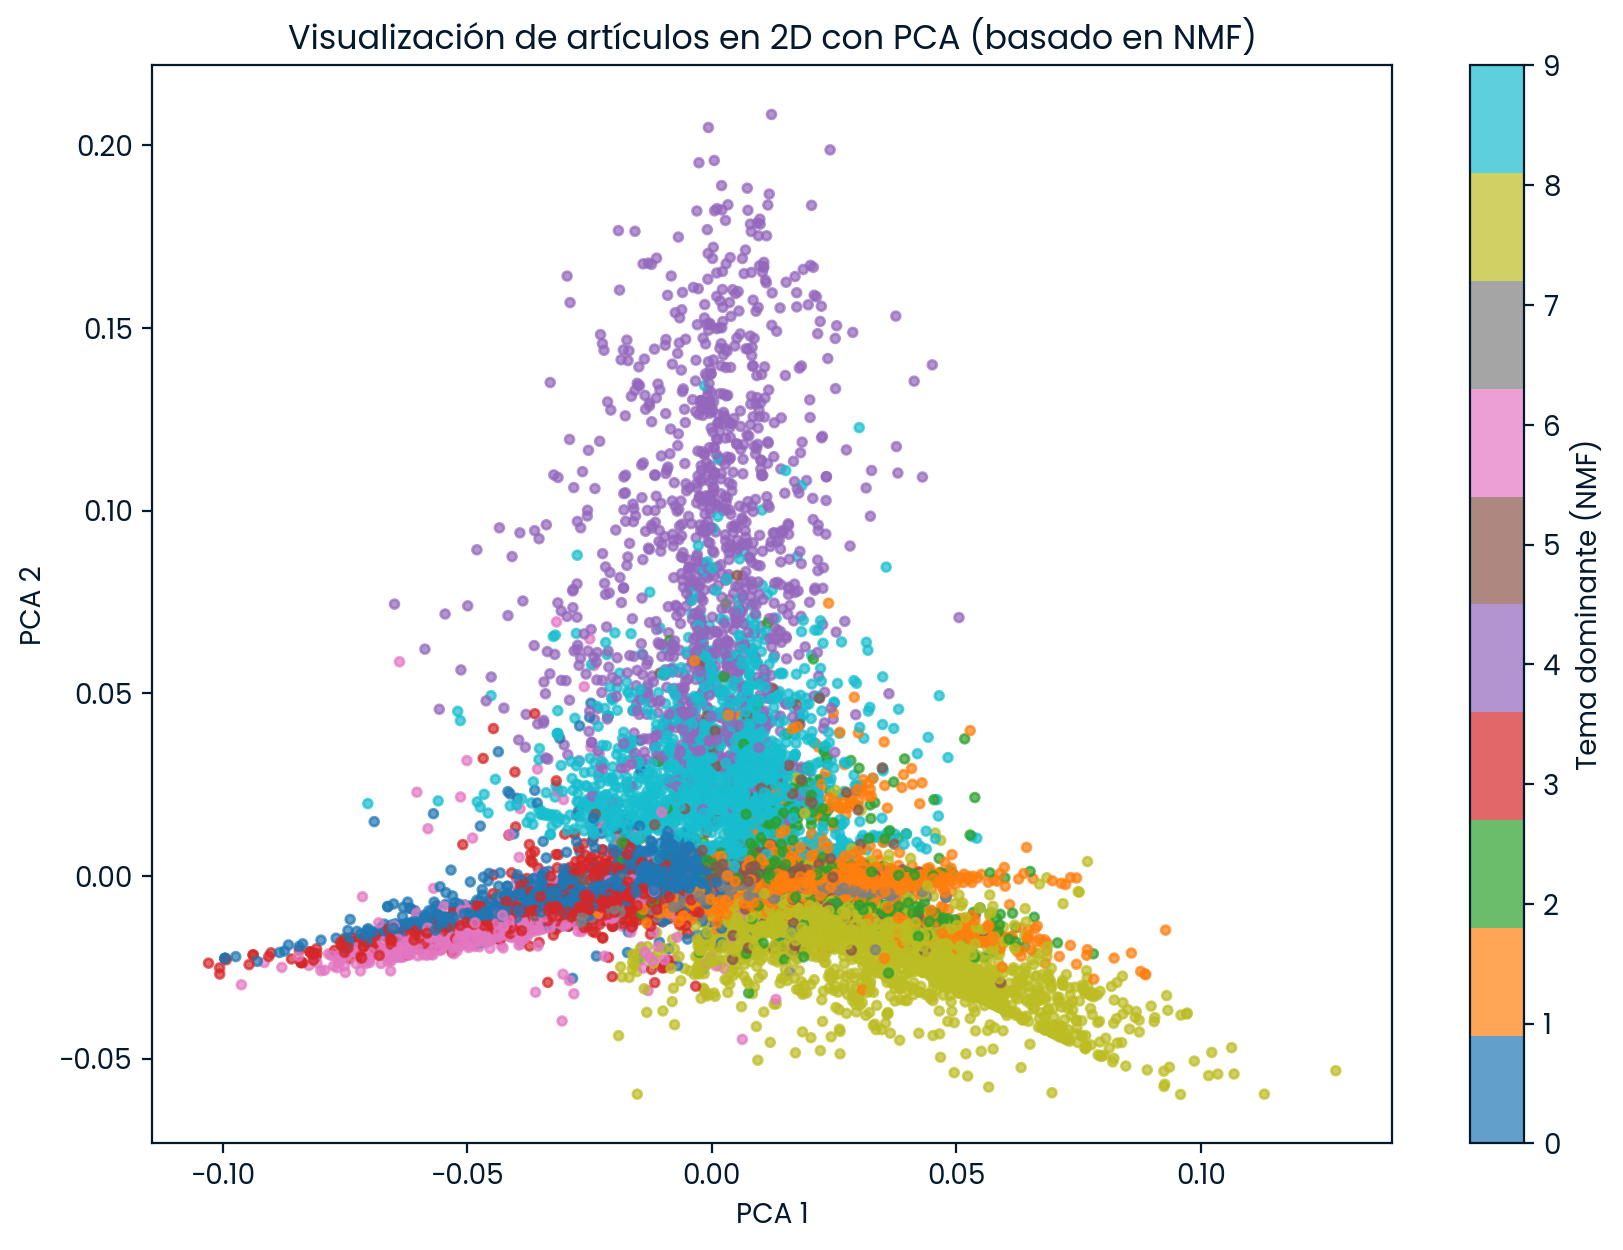

In [7]:
from sklearn.decomposition import PCA

# 📌 Inicializar el modelo PCA
# - n_components=2 → reducir los tópicos a 2 dimensiones
# - random_state=42 → asegurar reproducibilidad
pca = PCA(n_components=2, random_state=42)

# 📌 Reducir la matriz de tópicos a 2D usando PCA
X_pca = pca.fit_transform(X_topics)

# 📌 Mostrar qué porcentaje de la varianza total conservan las 2 componentes
print("Varianza explicada por PCA (2D):", pca.explained_variance_ratio_.sum())

# 📌 Crear figura para la visualización
plt.figure(figsize=(10, 7))

# 📌 Graficar cada documento en el plano 2D
# - X_pca[:, 0], X_pca[:, 1] → coordenadas de cada documento en 2D
# - c=X_topics.argmax(axis=1) → color según el tema dominante
# - cmap="tab10" → paleta de colores categóricos
# - s=10 → tamaño de punto
# - alpha=0.7 → transparencia
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_topics.argmax(axis=1), cmap="tab10", s=10, alpha=0.7)

# 📌 Barra de colores para identificar cada tema
plt.colorbar(label="Tema dominante (NMF)")

# 📌 Títulos y etiquetas
plt.title("Visualización de artículos en 2D con PCA (basado en NMF)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# 📌 Mostrar gráfico final
plt.show()
